In [194]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import altair as alt
from math import floor
pd.set_option('display.max_rows', 350)

from scipy.stats import randint


#modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split


## 1. Description

The dataset, provided by NYPD Police department, involves every shooting incident that occurred in NYC from 2006 to 2023. 
Each incident recorded contains information about time, date, precinct, Borough, victim profile (age, gender, race), perp profile (age, gender, race) and location information whereever available. 

In [195]:
##reading incident csv
raw_data = pd.read_csv("data/NYPD_Shooting_Incident_Data__Historic_.csv")

In [196]:
#converting time to 24hours format
raw_data.OCCUR_TIME = raw_data.OCCUR_TIME.apply(lambda x: "".join(x.split(":")[:2]))

In [197]:
# getting month, year, date
raw_data['OCCUR_MONTH'] =  raw_data.OCCUR_DATE.apply(lambda x: datetime.strptime(x, "%m/%d/%Y").month)
raw_data['OCCUR_YEAR']= raw_data.OCCUR_DATE.apply(lambda x: datetime.strptime(x, "%m/%d/%Y").year)
raw_data['OCCUR_DATE'] = raw_data.OCCUR_DATE.apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date)

In [198]:
# getting weekend 
raw_data["weekend"] = raw_data.OCCUR_DATE.apply(lambda x: False if x().weekday() < 5 else True)

In [199]:
# categorising time into 1 hour window
time_category_order = ["0-1", "1-2", "2-3", "3-4", "4-5","5-6","6-7",
"7-8","8-9", "9-10","10-11","11-12","12-13",
"13-14","14-15","15-16","16-17","17-18","18-19",
"19-20","20-21","21-22","22-23","23-00"]

months = ["jan", "feb", "march", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

def get_time_category (inp_time):
    return floor(int(inp_time)/100)

raw_data['time_category'] = raw_data.OCCUR_TIME.apply(lambda x: get_time_category(x))
raw_data['time_window'] = raw_data.time_category.apply(lambda x: time_category_order[x])

In [200]:
# removing geographical coord, race, gender info and location
data = raw_data.drop(columns=["X_COORD_CD","Y_COORD_CD","Latitude","Longitude","Lon_Lat", "LOC_OF_OCCUR_DESC","PRECINCT",
                              "JURISDICTION_CODE", "LOC_CLASSFCTN_DESC","LOCATION_DESC",
                              "STATISTICAL_MURDER_FLAG", "PERP_AGE_GROUP","PERP_SEX","PERP_RACE","VIC_AGE_GROUP",
                              "VIC_SEX","VIC_RACE", "OCCUR_DATE"])

# Explory data analysis

### WHEN: Timings of the shootings suggest it happens in late nights 

In [201]:
sample = raw_data.groupby(['time_window', 'time_category'], as_index=False).count()
alt.Chart(sample, width=600).mark_bar().encode(
    x = alt.X('time_window', sort=alt.EncodingSortField(field="time_category", order='ascending', op='max')),
    y = "BORO"
)

alt.Chart(...)

### WHEN: Shootings by months From may to oct, less shootings in cold temperatures?

In [202]:
sample = raw_data.groupby('OCCUR_MONTH', as_index=False).count()
alt.Chart(sample, width=500).mark_bar().encode(
    x = "OCCUR_MONTH:N",
    y = "BORO"

)

alt.Chart(...)

### WHEN: Shootings by weekend

In [230]:
sample = raw_data.groupby('weekend', as_index=False).count()
alt.Chart(sample, width=500).mark_bar().encode(
    x = "weekend:N",
    y = alt.Y("BORO", title = "shootings")

)

alt.Chart(...)

### WHERE: Distribution of shootings based on region, brooklyn and bronx make majority 
Location related info (inside /outside or )is missing 93%
most of shooting happens in multidwelling 


In [205]:
sample = raw_data.groupby('BORO', as_index=False).count()
# sample = sample.sort_values(by="PRECINCT", ascending=False, inplace=True)
alt.Chart(sample, width=500).mark_bar().encode(
    x = alt.X("BORO:O", sort='-y'),
    y = alt.Y("PRECINCT", title="Shooting count")
)

alt.Chart(...)

# 3. Modeling building and training

In [210]:
#converting boro to int
boro_map = {
    'QUEENS' : 1, 
    'BRONX' : 2, 
    'BROOKLYN' : 3, 
    'MANHATTAN' : 4, 
    'STATEN ISLAND' : 5,
}
def map_boro(inp):
    return boro_map[inp]
    

In [212]:
monthly_shooting_per_boro=data.groupby(["OCCUR_MONTH", "OCCUR_YEAR", "BORO", "time_category", "weekend"], as_index=False).count()
monthly_shooting_per_boro.head()

,OCCUR_MONTH,OCCUR_YEAR,BORO,time_category,weekend,INCIDENT_KEY,OCCUR_TIME,time_window
0,1,2006,BRONX,1,True,2,2,2
1,1,2006,BRONX,2,True,3,3,3
2,1,2006,BRONX,3,False,1,1,1
3,1,2006,BRONX,3,True,3,3,3
4,1,2006,BRONX,5,False,2,2,2


In [213]:
counts = Counter(monthly_shooting_per_boro.INCIDENT_KEY)
density_of_incidents = pd.DataFrame({
    "no_of_incidents": [x/sum(counts.values()) for x in counts.values()],
    "incident_count": counts.keys()
})

In [214]:
alt.Chart(density_of_incidents, width=500, title="Incidents per month per boro per time window").mark_line(point=True).encode(
    x = "incident_count" ,
    y = alt.Y("no_of_incidents", title="fraction of shooting"),
    tooltip="no_of_incidents"
).interactive()

alt.Chart(...)

## creating training data

In [215]:
train_data = monthly_shooting_per_boro[["OCCUR_MONTH", "BORO", "time_category", "weekend", "INCIDENT_KEY"]]

In [216]:
target = train_data.INCIDENT_KEY.apply(lambda x: 1 if x>3 else 0)

In [217]:
train_data["BORO"] = train_data.BORO.apply(lambda x: map_boro(x))

C:\Users\manpreet\AppData\Local\Temp\ipykernel_8440\3723189844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["BORO"] = train_data.BORO.apply(lambda x: map_boro(x))


In [218]:
train_data.head()

,OCCUR_MONTH,BORO,time_category,weekend,INCIDENT_KEY
0,1,2,1,True,2
1,1,2,2,True,3
2,1,2,3,False,1
3,1,2,3,True,3
4,1,2,5,False,2


In [219]:
X = train_data.drop(columns=["INCIDENT_KEY"], axis=1)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, target , test_size=0.4)

## Random forest Optimization (Tuning)

In [231]:
param_dist = {'n_estimators': list(range(1,200)),
              'max_depth': list(range(1,20))
             }

# Create a random forest classifier
rf = RandomForestClassifier(class_weight="balanced")

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, 
                                 scoring="precision",
                                 random_state=55
                                )

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=5,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=55, scoring='precision')

In [232]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
print("Best precision", rand_search.best_score_)

Best hyperparameters: {'n_estimators': 173, 'max_depth': 5}
Best precision 0.24769861933443202


Accuracy: 0.7189081706435285
Precision: 0.2344213649851632
Recall: 0.5984848484848485
F1: 


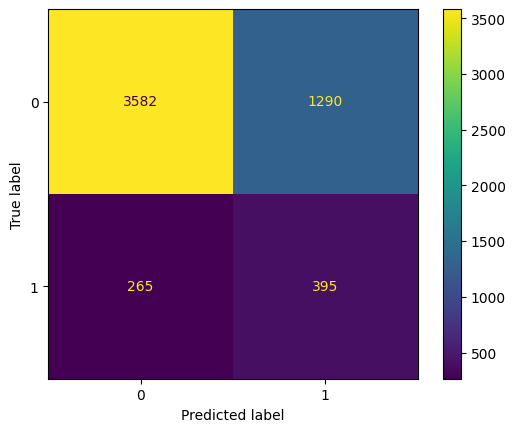

In [233]:
y_pred = best_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",  recall_score(y_test, y_pred))
print("F1: ", )
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [224]:
best_rf.feature_importances_

array([0.19763288, 0.32295803, 0.37089423, 0.10851486])

## XGboost Optimization (Tuning)

In [225]:
import xgboost as xgb

In [226]:
param_dist = {'n_estimators': list(range(1,100)),
              'max_depth': list(range(1,10)),
             'scale_pos_weight': list(range(1,10))}

# Create a random forest classifier
xg = xgb.XGBClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(xg, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5,
                                 scoring="precision", 
                                 random_state= 102
                                )

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...],
                                        'scale_pos_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9]},
                   random_state=102, scoring='precision')

In [227]:
# Create a variable for the best model
best_xg = rand_search.best_estimator_

# Print the 'best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_, "best score", rand_search.best_score_)


Best hyperparameters: {'scale_pos_weight': 1, 'n_estimators': 59, 'max_depth': 3} best score 0.5845357257121963


Accuracy: 0.8814172089660159
Precision: 0.5303030303030303
Recall: 0.05303030303030303


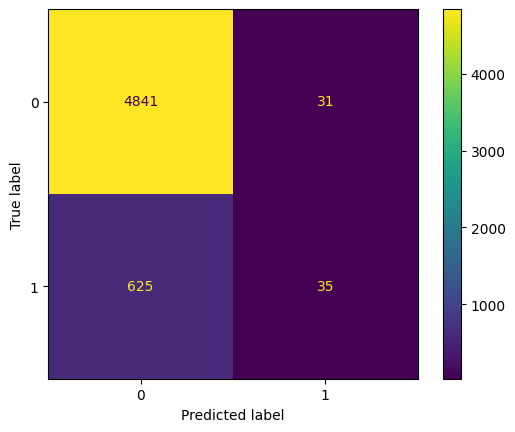

In [228]:
y_pred = best_xg.predict(X_test)

print("Accuracy:",  accuracy_score(y_test, y_pred))
print("Precision:",  precision_score(y_test, y_pred))
print("Recall:",  recall_score(y_test, y_pred))
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [229]:
best_xg.feature_importances_

array([0.17936374, 0.27637252, 0.20653959, 0.33772412], dtype=float32)

# Demo App

In [236]:
import gradio as gr

time_category_order = ["0-1", "1-2", "2-3", "3-4", "4-5","5-6","6-7",
"7-8","8-9", "9-10","10-11","11-12","12-13",
"13-14","14-15","15-16","16-17","17-18","18-19",
"19-20","20-21","21-22","22-23","23-00"]

def greet(month, boro, time_cat, weekend):
    #model prediction here
    test = pd.DataFrame({
        "OCCUR_MONTH" : months.index(month)+1,
        "BORO" : map_boro(boro),
        "time_category" : time_category_order.index(time_cat),
        "weekend": 1 if weekend else 0
    },
                        index=[0])
    pred = best_xg.predict(test)
    pred_rf = best_rf.predict(test)
    
    if pred[0] == 1:
        nypd =  "High alert"
    else:
        nypd = "Normal"

    if pred_rf[0] == 1:
        local = "High alert"
    else:
        local = "Normal"

    return nypd,local

demo = gr.Interface(fn=greet, inputs=
                    [
                      gr.Dropdown(["jan", "feb", "march", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"], label="Month", info="Month"),
                      gr.Dropdown(['QUEENS', 'BRONX', 'BROOKLYN',  'MANHATTAN', "STATEN ISLAND"], label="Boro", info="Boro"),
                      gr.Dropdown(time_category_order, label="Time", info="Time of day"),
                      gr.Dropdown(["Yes", "No"], label="Weekend", info="Is it a weekend"),
                    ], 
                    outputs=[
                        gr.Textbox(label="NYPD alert", info="what the police sees"),
                        gr.Textbox(label="Resident alert", info="what local residents see")
                    ])
    
if __name__ == "__main__":
    demo.launch()   

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
